In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter
import os

In [63]:
root = r'C:\Users\81004\Desktop\ptr2\data'
file_name = "2000-out_melt_out.xyz"
#########
file_path = os.path.join(root,file_name)

In [65]:
# 读取XYZ文件的函数，只提取F元素的原子
def read_xyz(file_path,ana_number):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    num_atoms = int(lines[0].strip())  # 获取原子数
    len_page = num_atoms+2
    atoms = []
    positions = []
    a,b,c = -1000,-1000,-1000
    # 从第3行开始读取元素和坐标，只提取F元素
    for line in lines[ana_number*len_page+2:(ana_number+1)*len_page]:
        parts = line.split()
        element = parts[0]
        if element == 'F':  # 只提取F元素
            x, y, z = map(float, parts[1:])
            if x>a:
                a=x
            if y>b:
                b=y
            if z>c:
                c=z
            atoms.append(element)
            positions.append([x, y, z])
    boxsize = [a+0.1,b+0.1,c+0.1]
    # print(boxsize)
    return np.array(positions), atoms, len(atoms),boxsize

In [67]:
# 处理周期性边界条件的函数
def apply_periodic_boundary(positions, box_size):
    # 对坐标应用周期性边界条件
    positions = positions % box_size  # 对坐标取模
    return positions

# 计算两点之间的周期性距离
def periodic_distance(p1, p2, box_size):
    delta = p2 - p1
    # 计算每个方向上的最小距离，考虑周期性边界条件
    delta = delta - np.round(delta / box_size) * box_size
    return np.linalg.norm(delta)

# 计算原子间的距离，并根据阈值判断是否连接
def compute_distances(positions, box_size, threshold):
    n_atoms = len(positions)
    adj_matrix = np.zeros((n_atoms, n_atoms), dtype=bool)
    
    for i in range(n_atoms):
        for j in range(i + 1, n_atoms):
            distance = periodic_distance(positions[i], positions[j], box_size)
            if distance < threshold:
                adj_matrix[i, j] = adj_matrix[j, i] = True
    
    return adj_matrix

# 非递归版本的深度优先搜索（DFS）
def find_clusters_iterative(adj_matrix):
    visited = np.zeros(adj_matrix.shape[0], dtype=bool)
    clusters = []
    
    for i in range(adj_matrix.shape[0]):
        if not visited[i]:
            cluster = []
            stack = [i]  # 使用栈来模拟递归
            while stack:
                node = stack.pop()
                if not visited[node]:
                    visited[node] = True
                    cluster.append(node)
                    # 将所有未访问的邻居节点加入栈中
                    for neighbor, connected in enumerate(adj_matrix[node]):
                        if connected and not visited[neighbor]:
                            stack.append(neighbor)
            clusters.append(cluster)
    
    return clusters

# 绘制团簇分布图
def plot_cluster_distribution(cluster_sizes):
    size_counts = Counter(cluster_sizes)
    sizes = list(size_counts.keys())
    counts = list(size_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(sizes, counts, width=0.5, align='center')
    plt.xlabel('Cluster Size (Number of Atoms)')
    plt.ylabel('Number of Clusters')
    plt.title('Cluster Size Distribution for F Atoms')
    plt.grid(True)
    plt.show()

# 主函数
def analyze_clusters(xyz_file,ana_number,threshold,boxsize):
    # 读取xyz文件，只提取F元素 
    positions, atoms, num_atoms,box_size = read_xyz(xyz_file,ana_number)
    if boxsize is not None:
        box_size = boxsize
    # 如果没有F元素，提前退出
    if num_atoms == 0:
        print("No F atoms found in the file.")
        return

    # 处理周期性边界条件
    positions = apply_periodic_boundary(positions, box_size)

    # 计算原子间的距离和邻接矩阵
    adj_matrix = compute_distances(positions, box_size,threshold)

    # 找到所有团簇
    clusters = find_clusters_iterative(adj_matrix)  # 使用非递归DFS

    # 统计团簇的原子数
    cluster_sizes = [len(cluster) for cluster in clusters]

    # 绘制团簇分布图
    # plot_cluster_distribution(cluster_sizes)

    # 数值输出：每个团簇的大小及其个数
    #print(f"Total number of clusters: {len(clusters)}")
    res_list = []
    for size, count in sorted(Counter(cluster_sizes).items()):
        # print(f"Cluster size: {size}, Count: {count}")
        res_list.append([size,count])

    # 输出最大团簇
    max_cluster_size = max(cluster_sizes)
    # print(f"Maximum cluster size: {max_cluster_size} atoms")
    
    return res_list

In [69]:
# 计算团簇的平均尺寸
# print(results)
def ana_results(results,def_cluster):
    free_F = 0
    count_cluster,num_atom_cluster = 0,0
    for size,num in results:
        if size<def_cluster:
            free_F+=num
        else:
            count_cluster+=1
            num_atom_cluster+=size*num
    average_size = num_atom_cluster/count_cluster
    return free_F,average_size,count_cluster


In [71]:
import matplotlib.pyplot as plt

def draw_x_y1_y2(frame,free_F,ave_size):
    # 提取数据列
    time = np.array(frame)*10
    free_f = free_F
    average_cluster_size = ave_size
    
    # 创建图形和轴
    fig, ax1 = plt.subplots()
    
    # 绘制 Free-F
    ax1.plot(time, free_f, color='tab:blue', label='Free-F', marker='o')
    ax1.set_xlabel('Time (ps)')
    ax1.set_ylabel('Free-F', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # 创建第二个 y 轴
    ax2 = ax1.twinx()
    
    # 绘制 average-cluster-size
    ax2.plot(time, average_cluster_size, color='tab:red', label='Average Cluster Size', marker='o')
    ax2.set_ylabel('Average Cluster Size', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # 设置标题
    plt.title('Free-F and Average Cluster Size vs Time')
    
    # 显示图表
    plt.tight_layout()
    plt.show()


In [215]:
root = r'C:\Users\81004\Desktop\ptr2\data'
file_name = "4000-out_melt_out.xyz"
#########
file_path = os.path.join(root,file_name)

In [217]:
# 分析帧数
intial_frame = 0
end_frame = 300
step_frame = 10
# F-F之间的距离
threshold = 3.8
# 定义大于4个F的团才称为团簇  因为一个Si上最多可以四个F
def_cluster = 5
# 分析的文件路径
xyz_file = file_path  
# 盒子尺寸 如果不考虑 直接None
boxsize = np.array([81.3982, 81.3982, 81.3982]) 

In [219]:
sum_all_data = {'frame':[],'free_F' : [],'ave_size':[],'num_cluster':[]}
for i_frame in range(intial_frame,end_frame+1,step_frame):
    # 运行主程序，分析团簇数据
    temp_results = analyze_clusters(xyz_file, i_frame, threshold ,boxsize)
    # 分析结果 解析团簇分布
    free_F,ave_size,num_atom_cluster = ana_results(temp_results,def_cluster)
    # 输出结果
    print(f'frame:{i_frame},free_F:{free_F}, num_cluster:{num_atom_cluster},ave_size:{round(ave_size,1)}')
    #print(f'团簇的数量为{num_atom_cluster}\n')
    # 存储数据
    sum_all_data['frame'].append(i_frame)
    sum_all_data['free_F'].append(free_F)
    sum_all_data['ave_size'].append(ave_size)
    sum_all_data['num_cluster'].append(num_atom_cluster)    

frame:0,free_F:122, num_cluster:17,ave_size:42.0
frame:10,free_F:12, num_cluster:23,ave_size:40.7
frame:20,free_F:7, num_cluster:16,ave_size:59.2
frame:30,free_F:4, num_cluster:15,ave_size:63.7
frame:40,free_F:7, num_cluster:11,ave_size:86.5
frame:50,free_F:2, num_cluster:9,ave_size:106.3
frame:60,free_F:5, num_cluster:8,ave_size:118.9
frame:70,free_F:5, num_cluster:8,ave_size:119.2
frame:80,free_F:6, num_cluster:6,ave_size:158.3
frame:90,free_F:7, num_cluster:6,ave_size:158.3
frame:100,free_F:4, num_cluster:6,ave_size:158.8
frame:110,free_F:3, num_cluster:5,ave_size:191.4
frame:120,free_F:2, num_cluster:5,ave_size:191.4
frame:130,free_F:3, num_cluster:5,ave_size:191.4
frame:140,free_F:1, num_cluster:4,ave_size:239.8
frame:150,free_F:8, num_cluster:4,ave_size:238.0
frame:160,free_F:4, num_cluster:4,ave_size:239.0
frame:170,free_F:0, num_cluster:4,ave_size:240.0
frame:180,free_F:2, num_cluster:4,ave_size:239.5
frame:190,free_F:1, num_cluster:4,ave_size:239.8
frame:200,free_F:3, num_clus

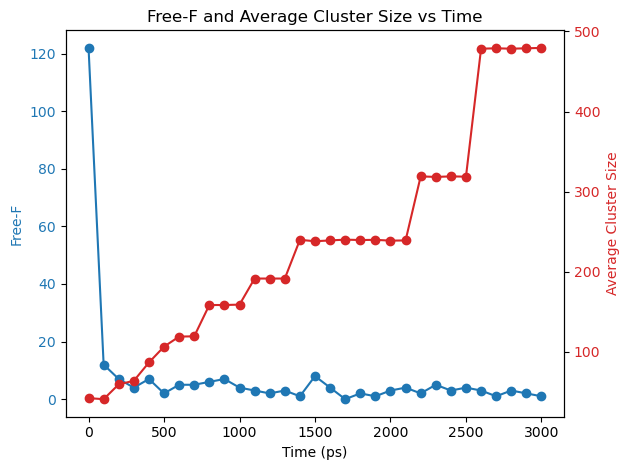

In [220]:
# 数据列表
frame,free_F,ave_size,num_cluster = sum_all_data.values()

draw_x_y1_y2(frame,free_F,ave_size)

Text(0.5, 1.0, 'Time - Ave_size')

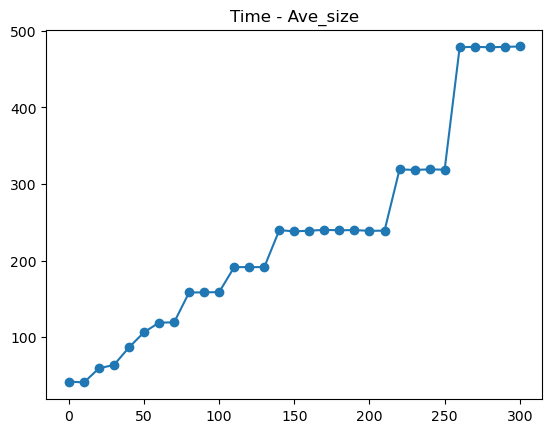

In [221]:
plt.plot(frame,ave_size,marker='o')
plt.title('Time - Ave_size')

In [222]:
# Stack as columns and save
save_path = os.path.join(root,'4000-clusters.txt')
np.savetxt(save_path, 
           np.column_stack((frame, ave_size,num_cluster)),
           header='Frame Average_Size', 
           fmt='%d %.4f %.4f')  # %d for integer, %.4f for float

In [91]:
i_ana_number = 200
# F-F之间的距离
i_threshold = 3.5
# 定义小于5个F的团才称为团簇  因为一个Si上最多可以四个F
i_def_cluster = 10
# 替换为你的xyz文件路径
i_xyz_file = file_path  
# 运行主程序，输入xyz文件路径
i_results = analyze_clusters(i_xyz_file , i_ana_number, i_threshold ,boxsize)
free_F,ave_size,num_atom_cluster = ana_results(i_results,i_def_cluster)
print(f'frame:{i_ana_number} 自由F离子数量有{free_F}个，F团簇中的原子数量平均有{round(ave_size,1)}个原子')
print(f'团簇的数量为{num_atom_cluster}')

frame:200 自由F离子数量有13个，F团簇中的原子数量平均有943.0个原子
团簇的数量为1


In [93]:


# 绘制平面上的F元素分布散点图
def plot_element_distribution(positions, plane='XY'):
    if plane == 'XY':
        x, y = positions[:, 0], positions[:, 1]
        xlabel, ylabel = 'X', 'Y'
    elif plane == 'YZ':
        y, z = positions[:, 1], positions[:, 2]
        xlabel, ylabel = 'Y', 'Z'
    elif plane == 'XZ':
        x, z = positions[:, 0], positions[:, 2]
        xlabel, ylabel = 'X', 'Z'
    else:
        raise ValueError("Plane must be 'XY', 'YZ', or 'XZ'.")
    
    # 绘制散点图
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, c='r', s=5, marker='o')  # 红色圆点，大小为5
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Element Distribution in {plane} Plane')
    plt.grid(True)
    plt.show()

# 主函数
def visualize_element_distribution(xyz_file,ana_number, plane='XY'):
    # 读取xyz文件，只提取F元素
    positions, atoms, num_atoms,boxsize = read_xyz(xyz_file,ana_number)

    # 如果没有F元素，提前退出
    if num_atoms == 0:
        print("No F atoms found in the file.")
        return
    
    # 绘制F元素分布图
    plot_element_distribution(positions, plane)



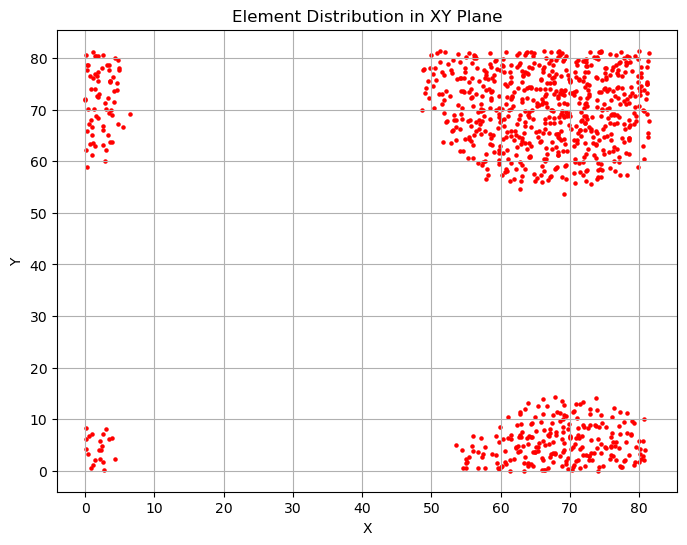

In [95]:
# 运行主程序，输入xyz文件路径
i_xyz_file = file_path  # 替换为你的xyz文件路径
i_ana_number = 200
# 选择要绘制的平面（'XY'，'YZ'，'XZ'）
visualize_element_distribution(i_xyz_file,i_ana_number, plane='XY')  # 'XY' 平面


In [97]:


# 处理周期性边界条件的函数
def apply_periodic_boundary(positions, box_size):
    # 对坐标应用周期性边界条件
    positions = positions % box_size  # 对坐标取模
    return positions

# 计算两点之间的周期性距离
def periodic_distance(p1, p2, box_size):
    delta = p2 - p1
    # 计算每个方向上的最小距离，考虑周期性边界条件
    delta = delta - np.round(delta / box_size) * box_size
    return np.linalg.norm(delta)

# 计算原子间的距离，并根据阈值判断是否连接
def compute_distances(positions, box_size, threshold):
    n_atoms = len(positions)
    adj_matrix = np.zeros((n_atoms, n_atoms), dtype=bool)
    
    for i in range(n_atoms):
        for j in range(i + 1, n_atoms):
            distance = periodic_distance(positions[i], positions[j], box_size)
            if distance < threshold:
                adj_matrix[i, j] = adj_matrix[j, i] = True
    
    return adj_matrix

# 非递归版本的深度优先搜索（DFS）
def find_clusters_iterative(adj_matrix):
    visited = np.zeros(adj_matrix.shape[0], dtype=bool)
    clusters = []
    
    for i in range(adj_matrix.shape[0]):
        if not visited[i]:
            cluster = []
            stack = [i]  # 使用栈来模拟递归
            while stack:
                node = stack.pop()
                if not visited[node]:
                    visited[node] = True
                    cluster.append(node)
                    # 将所有未访问的邻居节点加入栈中
                    for neighbor, connected in enumerate(adj_matrix[node]):
                        if connected and not visited[neighbor]:
                            stack.append(neighbor)
            clusters.append(cluster)
    
    return clusters

# 绘制平面上的F元素分布散点图并标出团簇
def plot_element_distribution_with_clusters(positions, clusters, plane='XY',mini_cluster=5):
    plt.figure(figsize=(7, 6))
    
    # 根据平面选择坐标轴
    if plane == 'XY':
        x, y = positions[:, 0], positions[:, 1]
        xlabel, ylabel = 'X', 'Y'
    elif plane == 'YZ':
        y, z = positions[:, 1], positions[:, 2]
        xlabel, ylabel = 'Y', 'Z'
    elif plane == 'XZ':
        x, z = positions[:, 0], positions[:, 2]
        xlabel, ylabel = 'X', 'Z'
    else:
        raise ValueError("Plane must be 'XY', 'YZ', or 'XZ'.")
    
    # 绘制所有原子的散点图
    plt.scatter(x, y, c='k', s=10, label='Atoms', alpha=0.5)
    ###
    lable_free = 0
    # 对每个团簇进行标注
    for cluster in clusters:
        cluster_positions = positions[cluster]
        cluster_x = cluster_positions[:, 0]
        cluster_y = cluster_positions[:, 1]
        
        # 根据团簇的大小，选择颜色
        cluster_size = len(cluster)
        color = plt.cm.jet(cluster_size / max(len(c) for c in clusters))  # 根据大小选择颜色
        
        # 绘制团簇的散点
        special_color = 'lightgreen'  # 设定为淡绿色
        if cluster_size<mini_cluster and lable_free==0:
            lable_free=1
            plt.scatter(cluster_x, cluster_y, c=[special_color]*len(cluster), s=30, label='Free atoms')
        elif cluster_size<mini_cluster and lable_free==1:
            plt.scatter(cluster_x, cluster_y, c=[special_color]*len(cluster), s=30)
        else:
            plt.scatter(cluster_x, cluster_y, c=[color]*len(cluster), s=30, label=f'Cluster {cluster_size} atoms')
        
        # 标出团簇的中心位置，并标注团簇大小
        center_x = np.mean(cluster_x)
        center_y = np.mean(cluster_y)
        plt.text(center_x, center_y, str(cluster_size), color='black', fontsize=10, ha='center', va='center')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Element Distribution with Clusters in {plane} Plane')
    #plt.grid(True)
    # plt.legend()
    # 设置图例位置，放置在图的右外边
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

# 主函数
def visualize_element_distribution_with_clusters(xyz_file, ana_number, mini_cluster, dis_cutoff,boxsize,plane='XY'):
    # 读取xyz文件，只提取F元素
    positions, atoms, num_atoms,box_size = read_xyz(xyz_file, ana_number)
    if boxsize is not None:
        box_size = boxsize
    # 如果没有F元素，提前退出
    if num_atoms == 0:
        print("No F atoms found in the file.")
        return
    
    # 处理周期性边界条件
    positions = apply_periodic_boundary(positions, box_size)

    # 计算原子间的距离和邻接矩阵
    adj_matrix = compute_distances(positions, box_size, dis_cutoff)

    # 找到所有团簇
    clusters = find_clusters_iterative(adj_matrix)  # 使用非递归DFS

    # 绘制F元素分布图和团簇
    plot_element_distribution_with_clusters(positions, clusters, plane, mini_cluster)




In [220]:
file_path = r"D:\MD_file\date\0304-ptr-msd\xyz-data\6k-out_melt_out.xyz"

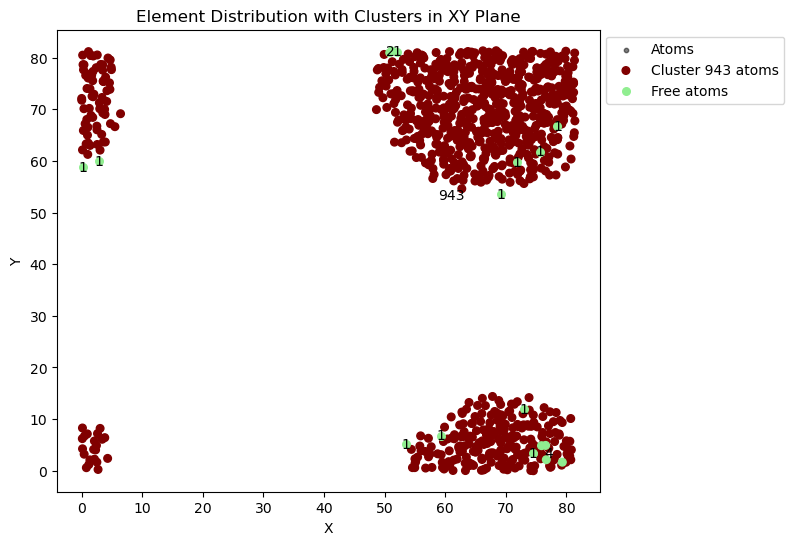

In [222]:
dis_cutoff = 3.5
mini_cluster = 10.0 
#
ana_number = 200
#
# 选择要绘制的平面（'XY'，'YZ'，'XZ'）
visualize_element_distribution_with_clusters(file_path, ana_number, mini_cluster = mini_cluster
                                             ,dis_cutoff=dis_cutoff,boxsize = boxsize, plane='XY')  # 'XY' 平面


In [ ]:
# 设置bins（团簇大小的区间，例如5表示每5个原子为一组）
bins = 20


In [77]:
# 计算F元素团簇的原子数分布，并按bins分组
def cluster_size_distribution(clusters, bins=5):
    cluster_sizes = [len(cluster) for cluster in clusters]
    
    # 按bins大小进行分组
    grouped_sizes = [bins * (size // bins) for size in cluster_sizes]  # 使用整除和乘法进行分组
    
    cluster_size_count = Counter(grouped_sizes)
    return cluster_size_count

# 绘制团簇大小分布图
def plot_cluster_size_distribution(cluster_size_count, bins=draw_bins):
    # 提取团簇大小和出现次数
    sizes = sorted(cluster_size_count.keys())
    counts = [cluster_size_count[size] for size in sizes]
    
    # 绘制柱状图
    plt.figure(figsize=(10, 6))
    plt.bar(sizes, counts, width=bins, color='skyblue', edgecolor='black')
    plt.xlabel(f'Cluster Size (Number of Atoms) in intervals of {bins}')
    plt.ylabel('Number of Clusters')
    plt.title(f'Cluster Size Distribution (Binned by {bins} atoms)')
    plt.grid(True)
    plt.show()

# 输出团簇大小分布数据
def output_cluster_size_distribution(cluster_size_count, output_file, bins=5):
    with open(output_file, 'w') as f:
        f.write(f"Cluster Size (Number of Atoms) in intervals of {bins}, Number of Clusters\n")
        for size, count in cluster_size_count.items():
            f.write(f"{size}, {count}\n")

# 主函数，结合之前的团簇分析部分
def analyze_and_plot_clusters(xyz_file, box_size, output_file, bins=5, plane='XY'):
    # 读取xyz文件，只提取F元素
    positions, atoms, num_atoms = read_xyz(xyz_file)

    # 如果没有F元素，提前退出
    if num_atoms == 0:
        print("No F atoms found in the file.")
        return
    
    # 处理周期性边界条件
    positions = apply_periodic_boundary(positions, box_size)

    # 计算原子间的距离和邻接矩阵
    adj_matrix = compute_distances(positions, box_size)

    # 找到所有团簇
    clusters = find_clusters_iterative(adj_matrix)  # 使用非递归DFS

    # 获取团簇大小分布
    cluster_size_count = cluster_size_distribution(clusters, bins)
    
    # 绘制团簇大小分布图
    plot_cluster_size_distribution(cluster_size_count, bins)
    
    # 输出团簇大小分布数据到文件
    output_cluster_size_distribution(cluster_size_count, output_file, bins)
    print(f"Cluster size distribution data saved to {output_file}")



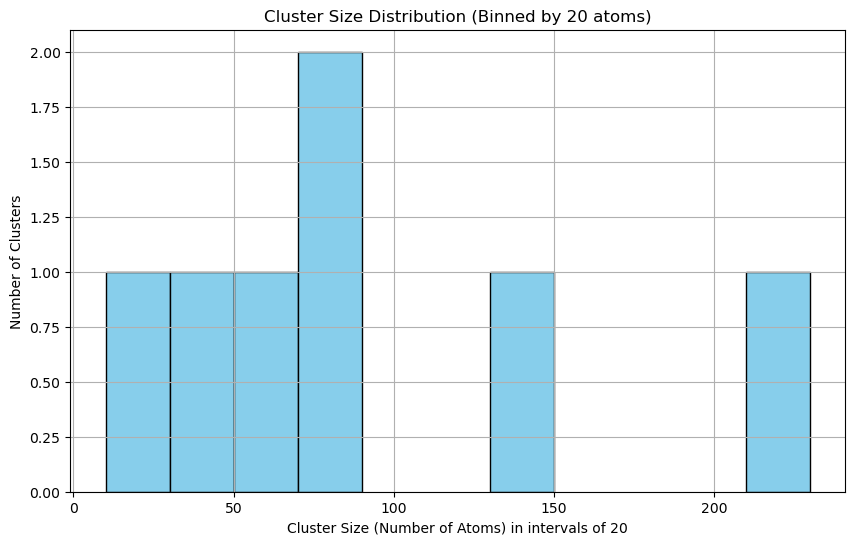

Cluster size distribution data saved to cluster_size_distribution.csv


In [79]:
output_file = 'cluster_size_distribution.csv'  # 输出文件名

# 运行主程序，绘制图并输出数据
analyze_and_plot_clusters(xyz_file, box_size, output_file, bins=bins, plane='XY')